In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

In [29]:
#Let's open the dataset and have a look at the columns
dataset = pd.read_csv("Walmart_Store_sales.csv")
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


# EDA

In [3]:
#8 columns and only 15O lines are in the dataset. Let's see if this will be enough to get correct predictions
dataset.info()
print(dataset.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB
(150, 8)


In [30]:
#It seems there are missings data in the dataset, lets clean it
dataset.isnull().sum()/dataset.shape[0]*100

Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [31]:
dataset = dataset[dataset["Weekly_Sales"].notna()]
dataset.isnull().sum()/dataset.shape[0]*100
#13% of the lines do  not have any dates. 

Store            0.000000
Date            13.235294
Weekly_Sales     0.000000
Holiday_Flag     8.088235
Temperature     11.029412
Fuel_Price       8.823529
CPI              8.088235
Unemployment    10.294118
dtype: float64

In [32]:
#Let's transform the date colum
dataset = dataset[dataset["Date"].notna()]
dataset['Date'] = pd.to_datetime(dataset['Date'],format= "%d-%m-%Y")
dataset["Year"] = dataset['Date'].dt.year
dataset['Month'] = dataset['Date'].dt.month
dataset['Day'] = dataset['Date'].dt.day
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28
6,15.0,2011-06-03,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3


In [22]:
dataset.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
count,118.000000,118,1.180000e+02,109.000000,107.000000,107.000000,109.000000,107.000000,118.000000,118.000000,118.000000
mean,9.949153,2011-04-23 04:28:28.474576384,1.257271e+06,0.073394,60.711589,3.291542,177.718009,7.681299,2010.822034,6.338983,16.440678
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000,2010.000000,1.000000,1.000000
25%,4.250000,2010-07-30 00:00:00,5.774276e+05,0.000000,45.465000,2.824000,131.637000,6.664000,2010.000000,4.000000,10.000000
50%,9.000000,2011-04-29 00:00:00,1.331001e+06,0.000000,61.790000,3.308000,194.379637,7.484000,2011.000000,6.000000,16.500000
75%,15.000000,2011-12-31 18:00:00,1.810591e+06,0.000000,75.430000,3.691500,214.777523,8.150000,2011.750000,9.000000,24.000000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000,2012.000000,12.000000,31.000000
std,6.066367,NaN,6.625056e+05,0.261987,17.961676,0.486784,39.816657,1.678155,0.812628,3.173664,8.209378


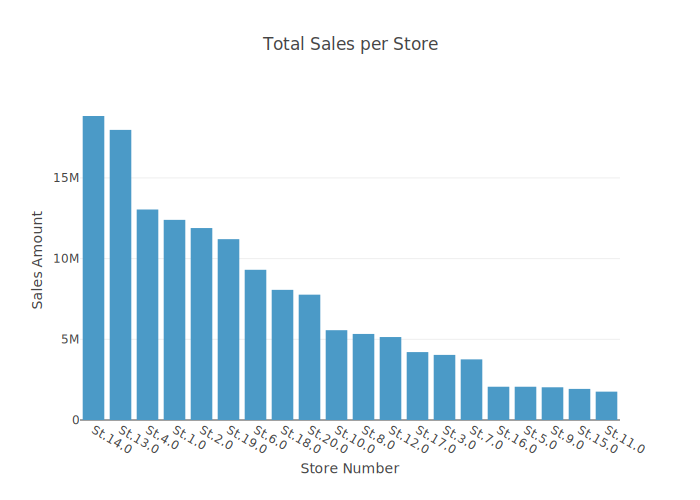

In [8]:
sales_by_store = dataset.groupby(['Store'])['Weekly_Sales'].sum().reset_index()
sales_by_store = sales_by_store.rename(columns={"Weekly_Sales":"Total_Sales"})
sales_by_store['Store'] = "St."+sales_by_store["Store"].astype(str)
sales_by_store = sales_by_store.sort_values(by="Total_Sales",ascending=False)
fig = px.bar(
        sales_by_store,
        x="Store",
        y="Total_Sales",
        title="Total Sales per Store",
        labels={"Store": "Store Number", "Total_Sales": "Sales Amount"})
fig.show()
#There is a large variety in the total sales per store

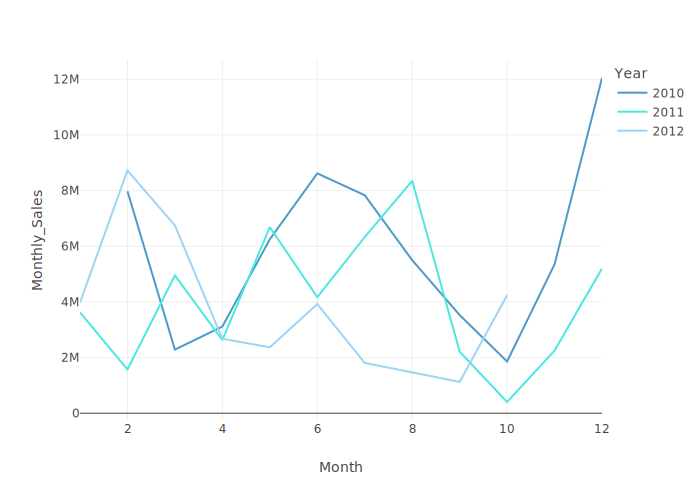

In [9]:
sales_per_month = dataset.groupby(['Year','Month'])['Weekly_Sales'].sum().reset_index()
sales_per_month = sales_per_month.rename(columns={"Weekly_Sales": "Monthly_Sales"})
fig = px.line(sales_per_month,x="Month",y="Monthly_Sales",color="Year")
fig.show()
#There does not seem to be any seasonality as there can have strong discrepencies for the same month between year

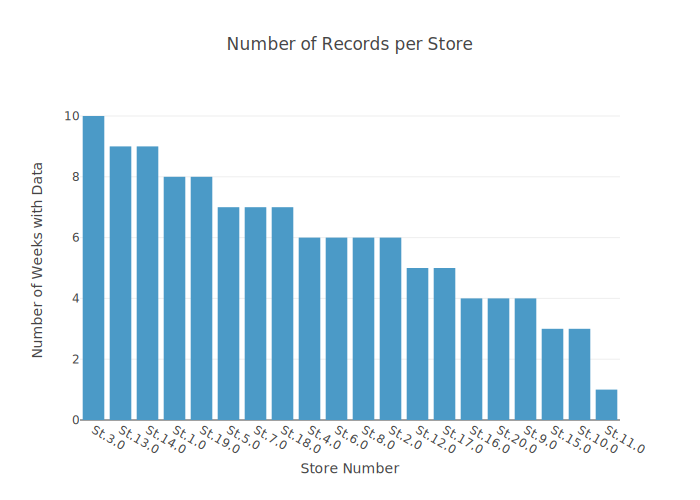

In [15]:
record_per_store = dataset.groupby(["Store"])['Weekly_Sales'].count().reset_index()

record_per_store = record_per_store.rename(columns={"Weekly_Sales": "Number_Records"})

record_per_store = record_per_store.sort_values(by="Number_Records", ascending=False)

record_per_store['Store'] = "St." + record_per_store["Store"].astype(str)

fig = px.bar(
    record_per_store,
    x="Store",
    y="Number_Records",
    title="Number of Records per Store",
    labels={"Store": "Store Number", "Number_Records": "Number of Weeks with Data"}
)

fig.show()
#No store seems to have complete data as there are maximum 10 records in the dataset of weekly sales

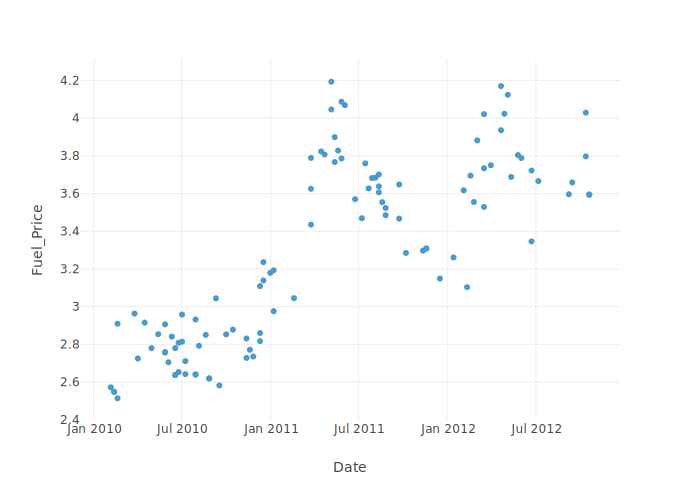

In [11]:
fig = px.scatter(dataset,x="Date",y="Fuel_Price")

fig.show()
#There were a strong variation in the fuel price between 2010 and 20212

In [33]:
#Droping outliers

print('Dropping outliers in Temperature ...')
low =  dataset['Temperature'].mean() - 3 *  dataset['Temperature'].std()
high =  dataset['Temperature'].mean() + 3 *  dataset['Temperature'].std()
print('The number of outliers in {} is {}'.format('Temperature', dataset.loc[(dataset['Temperature'] <= low) | (dataset['Temperature'] >= high)].shape[0]))


print('Dropping outliers in Fuel_price ...')
low =  dataset['Fuel_Price'].mean() - 3 *  dataset['Fuel_Price'].std()
high =  dataset['Fuel_Price'].mean() + 3 *  dataset['Fuel_Price'].std()
print('The number of outliers in {} is {}'.format('Fuel_Price', dataset.loc[(dataset['Fuel_Price'] <= low) | (dataset['Fuel_Price'] >= high)].shape[0]))


print('Dropping outliers in CPI ...')
low =  dataset['CPI'].mean() - 3 *  dataset['CPI'].std()
high =  dataset['CPI'].mean() + 3 *  dataset['CPI'].std()
print('The number of outliers in {} is {}'.format('CPI', dataset.loc[(dataset['CPI'] <= low) | (dataset['CPI'] >= high)].shape[0]))



print('Dropping outliers in Unemployment ...')
low =  dataset['Unemployment'].mean() - 3 *  dataset['Unemployment'].std()
high =  dataset['Unemployment'].mean() + 3 *  dataset['Unemployment'].std()
print('The number of outliers in {} is {}'.format('Unemployment', dataset.loc[(dataset['Unemployment'] <= low) | (dataset['Unemployment'] >= high)].shape[0]))

Dropping outliers in Temperature ...
The number of outliers in Temperature is 0
Dropping outliers in Fuel_price ...
The number of outliers in Fuel_Price is 0
Dropping outliers in CPI ...
The number of outliers in CPI is 0
Dropping outliers in Unemployment ...
The number of outliers in Unemployment is 5


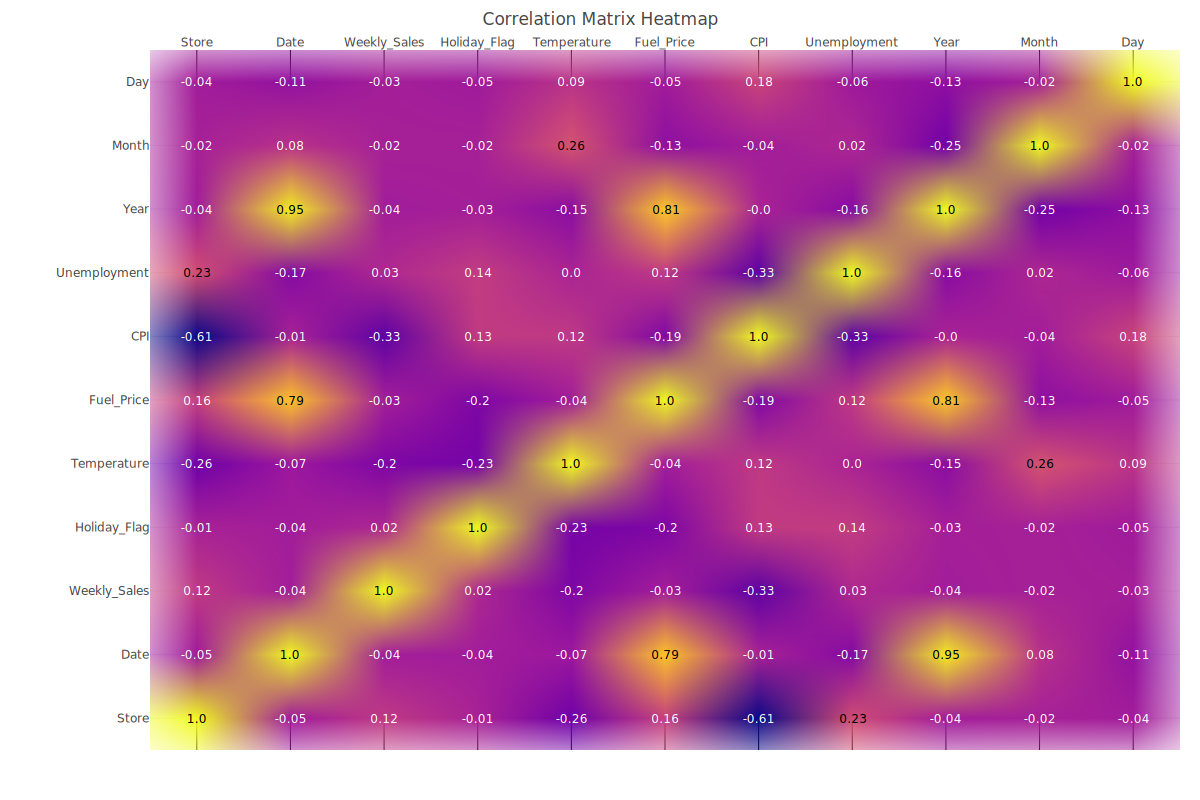

In [34]:
corr_matrix = dataset.corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())

fig.update_layout(
    width=1200, 
    height=800, 
    title="Correlation Matrix Heatmap",
    margin=dict(l=150, r=20, t=50, b=50)  # Adjust the margins (l=left, r=right, t=top, b=bottom)
)
fig.show()

#Weekly sales seems to be the most correlated with CPI
#Date and year a 

In [35]:
#Date and Year are heavily correlated so let's remove the date
to_drop = ['Date']
dataset.drop(columns=to_drop, inplace=True)
dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3


# Preprocessing

In [127]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "Weekly_Sales"

X = dataset.drop(target_variable, axis = 1)
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())



Separating labels from features...
...Done.

Y : 
0    1572117.54
1    1807545.43
4    1644470.66
5    1857533.70
6     695396.19
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
5    4.0           0.0          NaN       2.756  126.160226         7.896   
6   15.0           0.0        69.80       4.069  134.855161         7.658   

   Year  Month  Day  
0  2011      2   18  
1  2011      3   25  
4  2010      5   28  
5  2010      5   28  
6  2011      6    3  


In [128]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [131]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

#Actually, let's consider holiday and store as a categorical value
to_remove = ['Holiday_Flag',"Store"]

# Loop through each item in to_remove and pop it from the numeric_features list
for item in to_remove:
    numeric_features.remove(item)
    categorical_features.append(item)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)


Found numeric features  ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
Found categorical features  []
Found numeric features  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
Found categorical features  ['Holiday_Flag', 'Store']


In [132]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())

])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [133]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !!
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
139    7.0           0.0        50.60       3.804  197.588605         8.090   
16    13.0           0.0        76.34       2.850         NaN         7.951   
75    20.0           0.0        75.17       2.808  204.567546         7.856   
93    12.0           0.0          NaN       4.087  129.062355        13.736   
32     7.0           1.0        18.79       3.103  196.919506         8.256   

     Year  Month  Day  
139  2012      5   25  
16   2010      8   20  
75   2010      6   25  
93   2011      5   27  
32   2012      2   10  
...Done.
  (0, 0)	-0.6366747809299921
  (0, 1)	1.1744761028255861
  (0, 2)	0.5785541510735475
  (0, 3)	0.21259796784520513
  (0, 4)	1.4319302928057582
  (0, 5)	-0.4901602493193491
  (0, 6)	1.0805816673019866
  (0, 13)	1.0
  (1, 0)	0.853254454909728
  (1, 1)	-0.9024441985047835
  (1, 3)	0.1320292675897344
  (1, 4)	-0.9933210139283386
  (1

# Train Model

In [134]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [135]:
# Print R^2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))

R2 score on training set :  0.9790391088136594
R2 score on test set :  0.8920622878022378


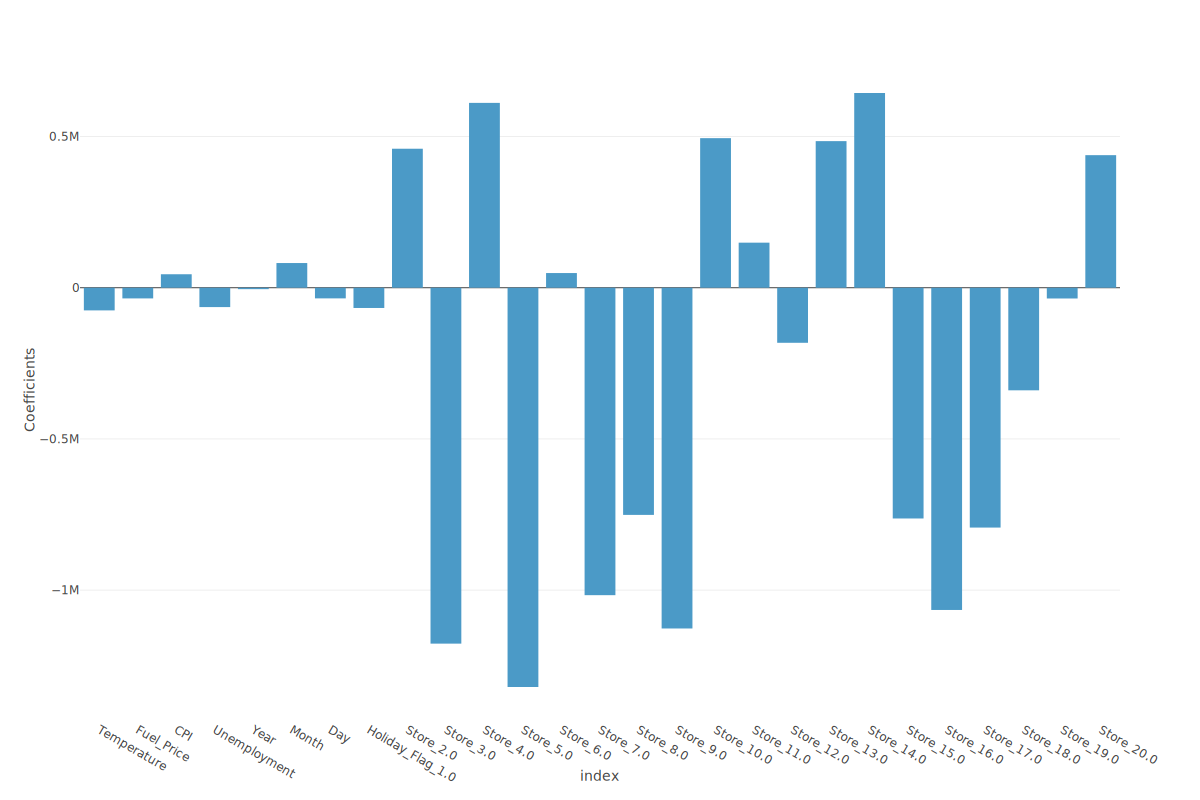

In [136]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

coefs = pd.DataFrame(
   regressor.coef_,
   columns=['Coefficients'], index=col_names
).reset_index()


fig = px.bar(coefs,x="index",y="Coefficients")
fig.update_layout(
    width=1200, 
    height=800, 
)
fig.show()

#We can see that the store number has a high correlation with the weekly sales, showing that each store has its own saels profile


# Regularization Ridge & Lasso

In [139]:
#Let's have a grid search for ridge

print("Ridge Grid search....")
regressor = Ridge()
params = {
    'alpha' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}

best_ridge = GridSearchCV(regressor, param_grid=params, cv= 5)
best_ridge.fit(X_train,Y_train)
print("...Done.")
print("Best hyperparameters : ", best_ridge.best_params_)
print("Best R2 score : ", best_ridge.best_score_)

# Perform Lasso grid search
print("LAsso Grid search...")
regressor = Lasso()
# Grid of values to be tested
params = {
    'alpha': [1, 2, 3, 5, 10, 20, 30]
}
best_lasso = GridSearchCV(regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
best_lasso.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_lasso.best_params_)
print("Best R2 score : ", best_lasso.best_score_)

Ridge Grid search....
...Done.
Best hyperparameters :  {'alpha': 0.01}
Best R2 score :  0.9543641657767999
LAsso Grid search...
...Done.
Best hyperparameters :  {'alpha': 30}
Best R2 score :  0.954428686689711


In [140]:
# Print R^2 scores
print("RIDGE / R2 score on training set : ", best_ridge.score(X_train, Y_train))
print("RIDGE / R2 score on test set : ", best_ridge.score(X_test, Y_test))
print()
print("LASSO / R2 score on training set : ", best_lasso.score(X_train, Y_train))
print("LASSO / R2 score on test set : ", best_lasso.score(X_test, Y_test))

RIDGE / R2 score on training set :  0.9790190500876504
RIDGE / R2 score on test set :  0.8920996908085785

LASSO / R2 score on training set :  0.9790372105007848
LASSO / R2 score on test set :  0.8922833622942123


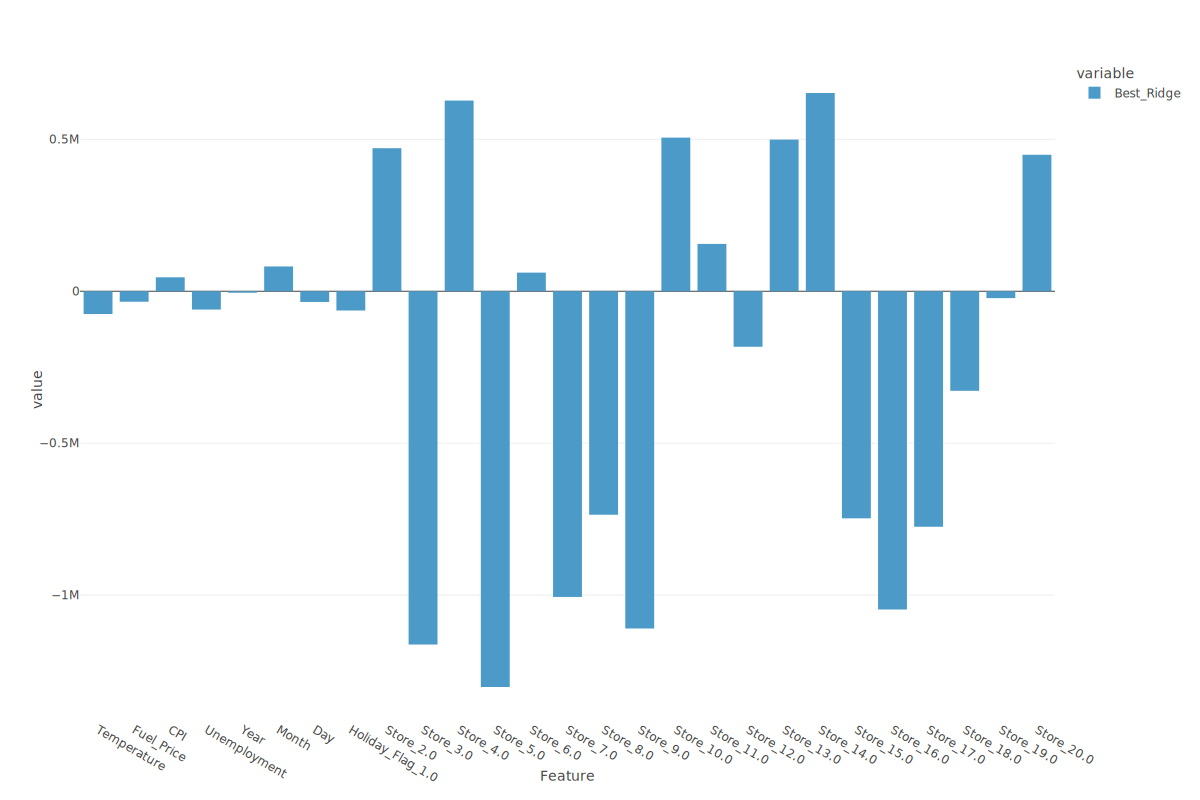

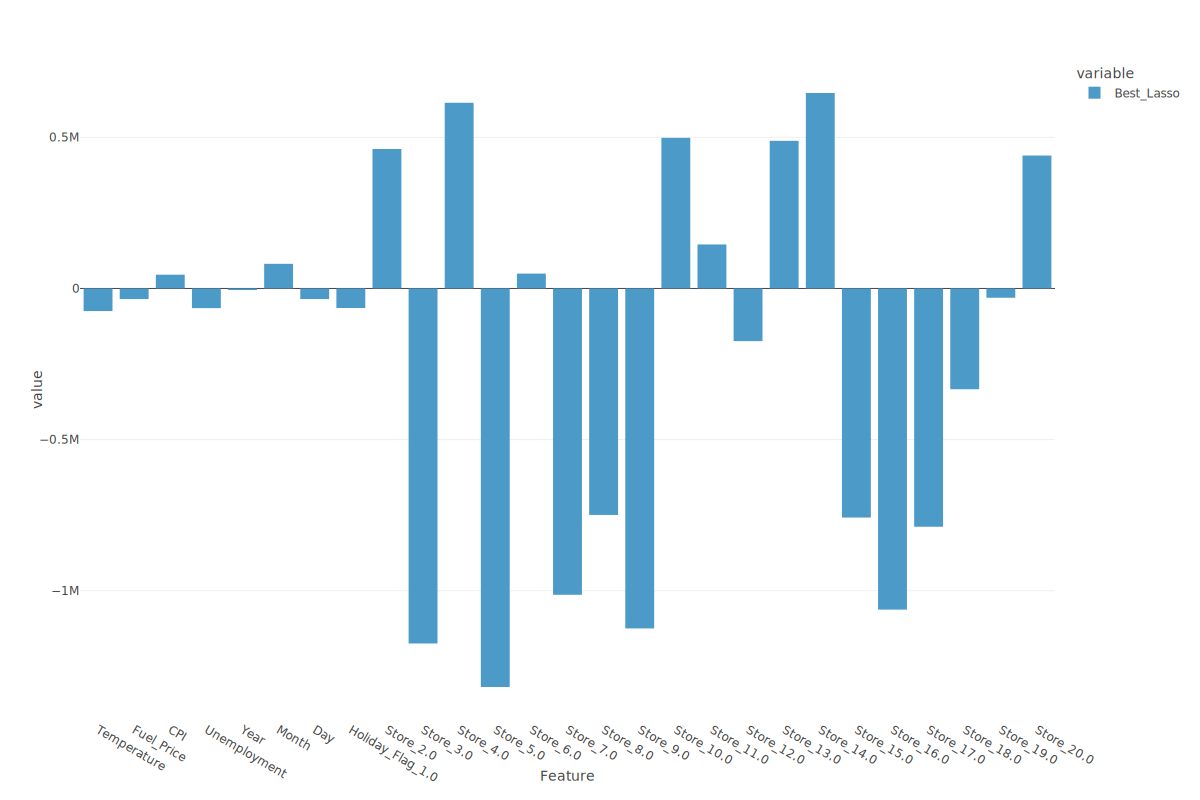

In [155]:
data_dict = {
    'Feature': col_names,
    'Best_Ridge': best_ridge.best_estimator_.coef_,
    'Best_Lasso': best_lasso.best_estimator_.coef_
            }

coefficients = pd.DataFrame(data = data_dict)

fig = px.bar(coefficients, x = 'Feature', y = ['Best_Ridge'])
fig.update_layout(
    width=1200, 
    height=800, 
)
fig.show()

fig = px.bar(coefficients, x = 'Feature', y = ['Best_Lasso'])
fig.update_layout(
    width=1200, 
    height=800, 
)
fig.show()

#Lasso and Ridge seems to have limited impact on the regression
#Overall, it seems that we are missing datapoints to fully predict. We have only 150 datapoints for 20 store, which seems to have their own specificities